<a href="https://colab.research.google.com/github/msitta/YAfisha/blob/main/Y_Afisha_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Otimização de Despesas de Marketing da Y.Afisha:**
# **Análise de Produto, Vendas e ROI**

## 1. Análise Preliminar

In [92]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st

In [93]:
# Os dataframes são carregados e os parâmetros parse_dates e dtype são utilizados para otimização de memória e tipo de dados.
costs_df = pd.read_csv('./Data_sets/costs_us.csv', parse_dates=['dt'])
orders_df = pd.read_csv('./Data_sets/orders_log_us.csv', parse_dates=['Buy Ts'])
visits_df = pd.read_csv('./Data_sets/visits_log_us.csv', parse_dates=['Start Ts', 'End Ts'], dtype={'Device': 'category'})

# Renomeação das colunas para que remetam mais facilmente a seus conteúdos.
costs_df.columns = ('source_id', 'date', 'costs' )
orders_df.columns = ('buy_ts', 'revenue', 'uid')
visits_df.columns = ('device', 'end_ts', 'source_id', 'start_ts', 'uid')

### Esta etapa visa confirmar se o carregamento está correto, os tipos de dados e identificar possíveis problemas.

In [95]:
print(costs_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   date       2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB
None


O dataframe é composto por três colunas, uma com valores 'int64', uma do tipo 'datetime64' (convertida a partir de uma coluna tipo 'str') e a terceira com valores 'float64'. A tabela contém 2542 linhas, sem valores NaN. O uso de memória é de 59.7 KB, o que indica que é leve e bem otimizado.

In [96]:
print(orders_df.info())
print()
print(orders_df['uid'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None

36523


Esse dataframe também é composto por três colunas, *'buy_ts'*, *'revenue'* e *'uid'*. A primeira é do tipo *'datetime64'* (convertida a partir de uma coluna tipo 'str'), a segunda contem valores *'float64'* e a terceira delas contém valores do tipo *'uint64'*, que contém números inteiros necessariamente positivos. A tabela contém 50415 linhas, sem valores NaN. O número de usuários unívocos na coluna *'uid'* é de 36523. O uso de memória é de 1.2 MB depois das melhorias feitas nos tipos de dados.


In [97]:
print(visits_df.info())
print()
print(visits_df['uid'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  category      
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB
None

228169


Esse dataframe é composto por cinco colunas, 'device', 'end_ts' e 'source_id', 'start_ts' e 'uid'. A coluna 'device' foi convertida de 'str' para 'category', a segunda contem valores 'datetime64', a terceira delas contém valores do tipo 'int64', a quarta também é do tipo 'datetime64' e a quinta é do tipo 'uint64'. O df contém 359400 linhas, sem valores NaN. O número de usuários unívocos na coluna 'uid' é de 228169. O uso de memória é de 11.3 MB depois das melhorias feitas nos tipos de dados.

**É de extrema importância a otimização de memória no carregamento dos dados, especialmente para conjuntos grandes. Os dtype e parse_dates contribuem para isso.**

## 2. Análise do Produto

In [98]:
# Extraindo dia, semana e mês para agrupamentos
visits_df['session_year'] = visits_df['start_ts'].dt.year
visits_df['session_month'] = visits_df['start_ts'].dt.month
visits_df['session_week'] = visits_df['start_ts'].dt.isocalendar().week
visits_df['session_date'] = visits_df['start_ts'].dt.date

# Visualizando se deu certo
print(visits_df.head())

    device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  session_year  session_month  session_week  \
0  16879256277535980062          2017             12            51   
1    104060357244891740          2018              2             8   
2   7459035603376831527          2017              7            26   
3  16174680259334210214          2018              5            20   
4   9969694820036681168          2017             12            52   

  session_date  
0   2017-12-20  
1   2018-02-19  
2   2017-07-01  
3   2018-05-20  
4   2017-12-27  


### Quantas pessoas usam-no cada dia (DAU), semana (WAU) e mês (MAU)?

In [99]:
# Calculando DAU, WAU e MAU
dau_total = visits_df.groupby('session_date')['uid'].nunique().mean().astype('uint32')
wau_total = visits_df.groupby(['session_year', 'session_week'])['uid'].nunique().mean().astype('uint32')
mau_total = visits_df.groupby(['session_year', 'session_month'])['uid'].nunique().mean().astype('uint32')
print('Média DAU:', dau_total)
print('Média WAU:', wau_total)
print('Média MAU:', mau_total)

Média DAU: 907
Média WAU: 5716
Média MAU: 23228


### Quantas sessões ocorrem por dia? (um usuário pode realizar várias sessões).

In [100]:
sessions_per_day = visits_df.groupby('session_date')['uid'].count().astype('uint32').mean()
print('A média de sessões diárias é de', int(sessions_per_day), '.')

A média de sessões diárias é de 987 .


No período analisado houve, em média, 987 sessões por dia no aplicativo. Consideramos aqui as várias sessões de um mesmo usuário que podem ocorrer durante um dia.

### Que comprimento tem cada sessão?

In [101]:
session_length = (visits_df['end_ts'] - visits_df['start_ts']).mean()
session_length_sec = session_length.total_seconds()
print(session_length)

0 days 00:10:43.025687256


Cada sessão leva, em média, pouco menos de 11 minutos.

### Com que frequência os usuários voltam?
Aqui calcularemos os "sticky factors"

In [102]:
sticky_factor_w = (dau_total / wau_total) * 100
sticky_factor_m = (dau_total / mau_total) * 100

dias_por_semana = (sticky_factor_w * 7) / 100
print(f'Sticky Factor Semanal: {sticky_factor_w:.2f}%')
print(f'Isso significa que os usuários acessam, em média, {dias_por_semana:.1f} dias por semana.')
print()

dias_por_mes = (sticky_factor_m * 30) / 100
print(f'Sticky Factor Mensal: {sticky_factor_m:.2f}%')
print(f'Isso significa que os usuários acessam, em média, {dias_por_mes:.1f} dias por mês.')

Sticky Factor Semanal: 15.87%
Isso significa que os usuários acessam, em média, 1.1 dias por semana.

Sticky Factor Mensal: 3.90%
Isso significa que os usuários acessam, em média, 1.2 dias por mês.


## 3. Análise das Vendas

### Quando as pessoas começam a comprar?

Tempo médio de conversão (dias): 16.7298688497659
days_to_purchase
0     26363
1      1011
2       563
3       434
4       324
5       270
6       260
7       218
8       189
10      140
Name: count, dtype: int64


<Axes: >

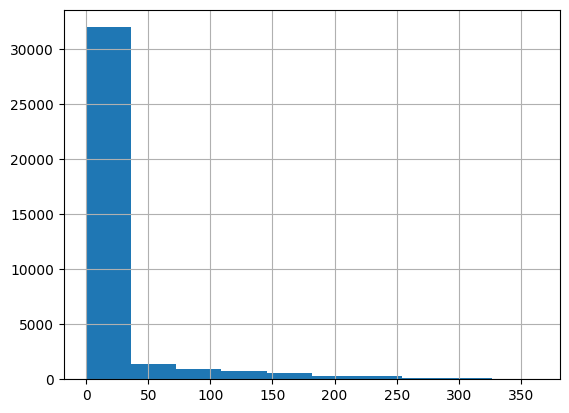

In [103]:
# Achar a primeira visita de cada usuário
first_visits = visits_df.groupby('uid')['start_ts'].min().reset_index()
first_visits.columns = ['uid', 'first_visit_dt']

# Achar a primeira compra de cada usuário
first_orders = orders_df.groupby('uid')['buy_ts'].min().reset_index()
first_orders.columns = ['uid', 'first_order_dt']

# Juntar as duas tabelas (apenas usuários que compraram vão aparecer)
conversion = pd.merge(first_visits, first_orders, on='uid')

# Calcular a diferença
conversion['days_to_purchase'] = (conversion['first_order_dt'] - conversion['first_visit_dt']).dt.days

# Agora podemos ver a média e o histograma para termos uma ideia da distribuição
print('Tempo médio de conversão (dias):', conversion['days_to_purchase'].mean())
print(conversion['days_to_purchase'].value_counts().head(10)) # Para ver quantos convertem em 0 dias
(conversion['days_to_purchase']).hist(bins=10)

Podemos perceber que a maioria dos usuários já compra no primeiro dia, ou seja, no mesmo dia em que se cadastram no serviço. O tempo médio para que um usuário se torne um cliente é de pouco mais de 16 dias, ou seja, leva aproximadamente 16 dias para que um usuário realize sua primeira compra, em média.

 ### Quantos pedidos os clientes fazem durante um determinado período de tempo?

Análise de Comportamento (Mensal):
             total_orders  total_buyers  avg_ticket  orders_per_buyer
order_month                                                          
2017-06-01           2354          2023    4.060106          1.163618
2017-07-01           2363          1984    5.306589          1.191028
2017-08-01           1807          1472    4.847139          1.227582
2017-09-01           3387          2750    5.416448          1.231636
2017-10-01           5679          4675    4.928280          1.214759


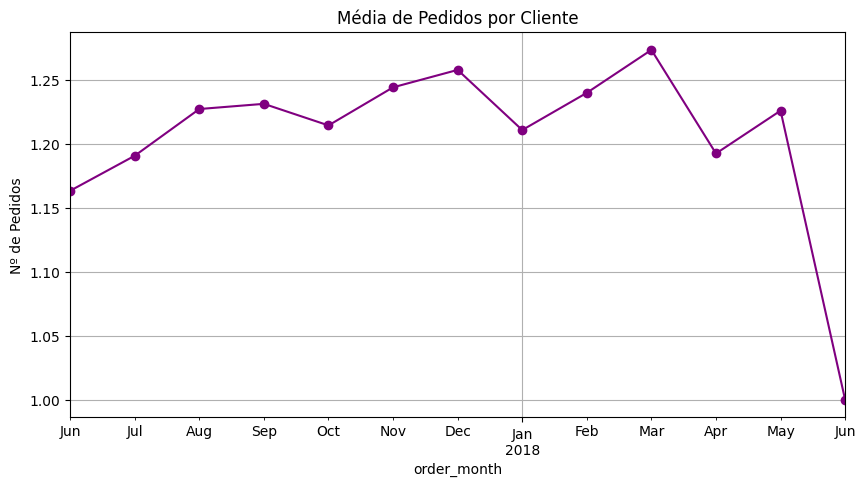

In [104]:
orders_df['order_month'] = orders_df['buy_ts'].dt.to_period('M').dt.to_timestamp()

# Agora o agrupamento vai funcionar
orders_month_report = orders_df.groupby('order_month').agg({
    'uid': ['count', 'nunique'],
    'revenue': 'mean'
})

# Renomeando as colunas
orders_month_report.columns = ['total_orders', 'total_buyers', 'avg_ticket']

# Calcular a métrica de frequência
orders_month_report['orders_per_buyer'] = orders_month_report['total_orders'] / orders_month_report['total_buyers']

print('Análise de Comportamento (Mensal):')
print(orders_month_report.head())

# --- Gráfico ---
orders_month_report['orders_per_buyer'].plot(figsize=(10, 5), grid=True, marker='o', color='purple', title='Média de Pedidos por Cliente')
import matplotlib.pyplot as plt
plt.ylabel('Nº de Pedidos')
plt.show()

Podemos deduzir que a média de compras por mês, por cliente, manteve-se relativamente estável entre junho de 2017 e maio de 2018, com os meses de dezembro de 2017 e março de 2018 destacando-se pelo pico percebido nessa média. Notam-se também vales, ou, pelo menos, quedas abruptas nos meses de janeiro e abril de 2018. O mês de junho de 2018 deve ser desconsiderado, já que os dados são deficitários para que sejam extraídas conclusões.

 ### Qual é o volume médio de uma compra?

Volume Médio Geral de Compra: $5.00

Volume Médio por Mês (Amostra):
order_month
2017-06-01    4.060106
2017-07-01    5.306589
2017-08-01    4.847139
2017-09-01    5.416448
2017-10-01    4.928280
2017-11-01    4.783518
2017-12-01    5.852139
2018-01-01    4.112927
2018-02-01    4.840095
2018-03-01    5.413930
2018-04-01    5.150645
2018-05-01    4.771279
2018-06-01    3.420000
Name: revenue, dtype: float64


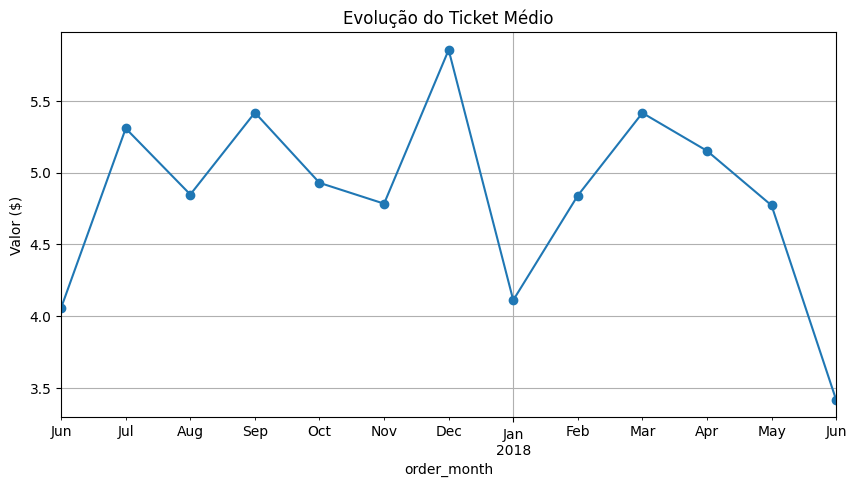

In [105]:
# Ticket Médio GERAL (De todo o período)
avg_order_value = orders_df['revenue'].mean()
print(f"Volume Médio Geral de Compra: ${avg_order_value:.2f}")

# Ticket Médio POR MÊS (Para ver a tendência)
# Agrupamos por mês e tiramos a média da receita
monthly_avg_check = orders_df.groupby('order_month')['revenue'].mean()

print("\nVolume Médio por Mês (Amostra):")
print(monthly_avg_check)

monthly_avg_check.plot(figsize=(10, 5), grid=True, marker='o', title='Evolução do Ticket Médio')
plt.ylabel('Valor ($)')
plt.show()

Aqui notamos uma menor regularidade nos valores médios das compras mês a mês. Há um pico evidente no mês de dezembro de 2017. Outro mês notável é o de janeiro de 2018, em que quase se atingiu o menor patamar da séwrie. Desconsideraremos aqui, também, o mês de junho de 2018, por o considerarmos um outlier (com somente um pedido registrado).

### Qual é a origem dos usuários/clientes?

In [106]:
# Identificar o canal da primeira visita (Origem de Aquisição)
first_visit_source = visits_df.sort_values(['uid', 'start_ts']).groupby('uid').first()['source_id'].reset_index()
first_visit_source.columns = ['uid', 'acquisition_channel']
print(first_visit_source.head())

               uid  acquisition_channel
0   11863502262781                    3
1   49537067089222                    2
2  297729379853735                    3
3  313578113262317                    2
4  325320750514679                    5


Unimos as duas tabelas: *conversion* e *first_visit_source*.

In [107]:
# Unir a origem com os dados de tempo de conversão
conversion_channel = conversion.merge(first_visit_source, on='uid')
print("Tabela unificada (Tempo + Canal):")
print(conversion_channel.head())

Tabela unificada (Tempo + Canal):
                uid      first_visit_dt      first_order_dt  days_to_purchase  \
0   313578113262317 2017-09-18 22:49:00 2018-01-03 21:51:00               106   
1  1575281904278712 2017-06-03 10:13:00 2017-06-03 10:13:00                 0   
2  2429014661409475 2017-10-11 17:14:00 2017-10-11 18:33:00                 0   
3  2464366381792757 2018-01-27 20:10:00 2018-01-28 15:54:00                 0   
4  2551852515556206 2017-11-24 10:14:00 2017-11-24 10:14:00                 0   

   acquisition_channel  
0                    2  
1                   10  
2                    3  
3                    5  
4                    5  


Apesar de ser um dado isolado, no primeiro registro do df, temos um cliente que levou 106 dias para realizar a primeira compra. Ele chegou ao serviço pelo canal **2**.

Descobrimos qual é a **mediana** do tempo em dias para a primeira compra. Evitamos, assim, distorções na média que poderiam ser causadas por *outliers*.

In [108]:
# Calcular o tempo mediano de conversão por canal
median_conversion = conversion_channel.groupby('acquisition_channel')['days_to_purchase'].median()
print("Tempo Mediano de Conversão por Canal (em dias):")
print(median_conversion.sort_values())

Tempo Mediano de Conversão por Canal (em dias):
acquisition_channel
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
7     0.0
10    0.0
9     3.0
Name: days_to_purchase, dtype: float64


Aqui é possível notar que a mediana do tempo de conversão é, na maioria dos canais, de 0 dias. Exceção se nota no canal **9**, cuja mediana é de três dias.

Vamos verificar quais canais tem o menor tempo de conversão.

In [109]:
# Analisar conversões imediatas (Dia 0)
conversion_channel['is_0d_conversion'] = conversion_channel['days_to_purchase'] == 0
conversion_speed = conversion_channel.groupby('acquisition_channel').agg({'uid': 'count', 'is_0d_conversion': 'mean'}).reset_index()
conversion_speed.columns = ['source_id', 'total_buyers', 'pct_conversion_0d']
conversion_speed['pct_conversion_0d'] = (conversion_speed['pct_conversion_0d'] * 100).round(1)
print("Ranking de Eficiência (Conversão Imediata):")
print(conversion_speed.sort_values('pct_conversion_0d', ascending=False))

Ranking de Eficiência (Conversão Imediata):
   source_id  total_buyers  pct_conversion_0d
5          7             1              100.0
0          1          2899               78.6
4          5          6931               76.9
7         10          1329               76.5
3          4         10296               71.9
2          3         10473               71.3
1          2          3506               67.9
6          9          1088               45.3


Começamos a perceber que os canais **3** e **4**, aparentemente, trazem uma quantidade maior de clientes que convertem no dia do cadastro, e a diferença entre eles e os demais canais é bastante evidente.

 ### Quanto dinheiro eles trazem para a empresa (LTV)?

In [110]:
# Preparar a Coorte (Mês da primeira compra)
first_orders['first_order_month'] = first_orders['first_order_dt'].dt.to_period('M').dt.to_timestamp()
# Juntamos essa informação na tabela principal de pedidos
orders_new = pd.merge(orders_df, first_orders[['uid', 'first_order_month']], on='uid')

# Calcular a "Idade" da compra (Cohort Age)
orders_new['age_month'] = (
    (orders_new['order_month'].dt.year - orders_new['first_order_month'].dt.year) * 12 +
    (orders_new['order_month'].dt.month - orders_new['first_order_month'].dt.month)
)

# Calcular Tamanho das Coortes (n_buyers)
cohort_sizes = orders_new.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

# Tabela de Receita (Pivot Table)
cohorts_revenue = orders_new.pivot_table(
    index='first_order_month',
    columns='age_month',
    values='revenue',
    aggfunc='sum'
)

# Calcular o LTV (Receita / n_buyers) e Acumular
ltv = cohorts_revenue.divide(cohort_sizes.set_index('first_order_month')['n_buyers'], axis=0)
ltv_cumulative = ltv.cumsum(axis=1)

print("--- LTV Acumulado por Coorte ---")
ltv_print = ltv_cumulative.copy()
ltv_print.index = ltv_print.index.strftime('%Y-%m')
print(ltv_print.round(2).fillna(''))

--- LTV Acumulado por Coorte ---
age_month            0     1     2      3      4      5      6      7      8   \
first_order_month                                                               
2017-06            4.72  5.21  5.65    6.6   7.62   8.36   9.31   9.89  10.45   
2017-07            6.01  6.35  6.97   7.33    7.5   7.66   7.78   7.92   8.08   
2017-08            5.28  5.75  6.21    6.6   7.09   7.38   7.59   7.99   8.28   
2017-09            5.64  6.76  7.28  11.26  11.66  12.31  13.01  13.25  13.44   
2017-10            5.00  5.54  5.73   5.89   6.04   6.16   6.24   6.36          
2017-11            5.15  5.55  5.75   6.08   6.23   6.28    6.4                 
2017-12            4.74   5.0  5.92   6.99    7.3   7.64                        
2018-01            4.14  4.43  4.73   4.88   4.94                               
2018-02            4.16  4.44  4.51   4.59                                      
2018-03            4.84  5.14  5.46                                         

O LTV demonstra o teto de receita que podemos esperar de cada cliente. Agora, precisamos comparar esse valor com o Custo de Aquisição (CAC) para saber se esse retorno é suficiente para gerar lucro (ROI).

### Análise de Dispositivos

/tmp/ipython-input-662173285.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion_device.index, y=conversion_device.values, ax=ax[1], palette='pastel')


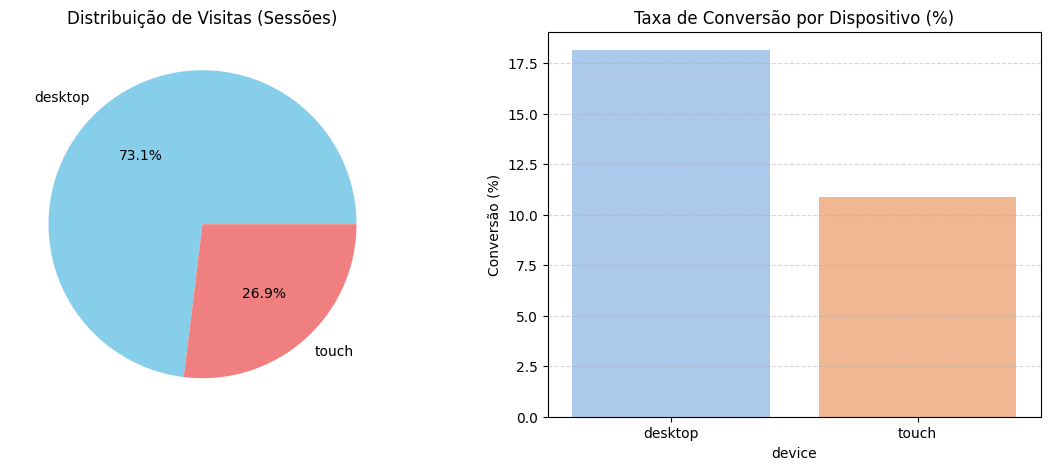

Taxa de Conversão por Dispositivo:
device
desktop    18.15%
touch      10.88%
Name: count, dtype: object


In [111]:
# Volume: Quantas visitas cada dispositivo recebe?
visits_by_device = visits_df['device'].value_counts()

# Conversão: Qual dispositivo vende mais?
# Primeiro, pegamos o dispositivo da PRIMEIRA visita de cada usuário
first_device = visits_df.sort_values('start_ts').groupby('uid').first()['device']

# Identificamos quem comprou
buyers = orders_df['uid'].unique()

# Filtramos apenas os dispositivos dos compradores
buyers_device = first_device[first_device.index.isin(buyers)].value_counts()

# Calculamos a taxa de conversão (Compradores / Total de Visitantes Únicos)
total_visitors_device = visits_df.groupby('uid')['device'].first().value_counts()
conversion_device = (buyers_device / total_visitors_device * 100)

# --- Gráficos ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Quem visita mais? (Pizza)
ax[0].pie(visits_by_device, labels=visits_by_device.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
ax[0].set_title('Distribuição de Visitas (Sessões)')

# Gráfico 2: Quem converte mais? (Barra)
sns.barplot(x=conversion_device.index, y=conversion_device.values, ax=ax[1], palette='pastel')
ax[1].set_title('Taxa de Conversão por Dispositivo (%)')
ax[1].set_ylabel('Conversão (%)')
ax[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

# Print dos números exatos
print("Taxa de Conversão por Dispositivo:")
print(conversion_device.round(2).astype(str) + '%')

## 4. Análise de Marketing

### Quanto dinheiro foi gasto? (Total, Por Origem e Ao Longo do Tempo)

Investimento Total em Marketing: $329,131.62

--- Gasto por Origem ---
   source_id      costs
2          3  141321.63
3          4   61073.60
4          5   51757.10
1          2   42806.04
0          1   20833.27
6         10    5822.49
5          9    5517.49


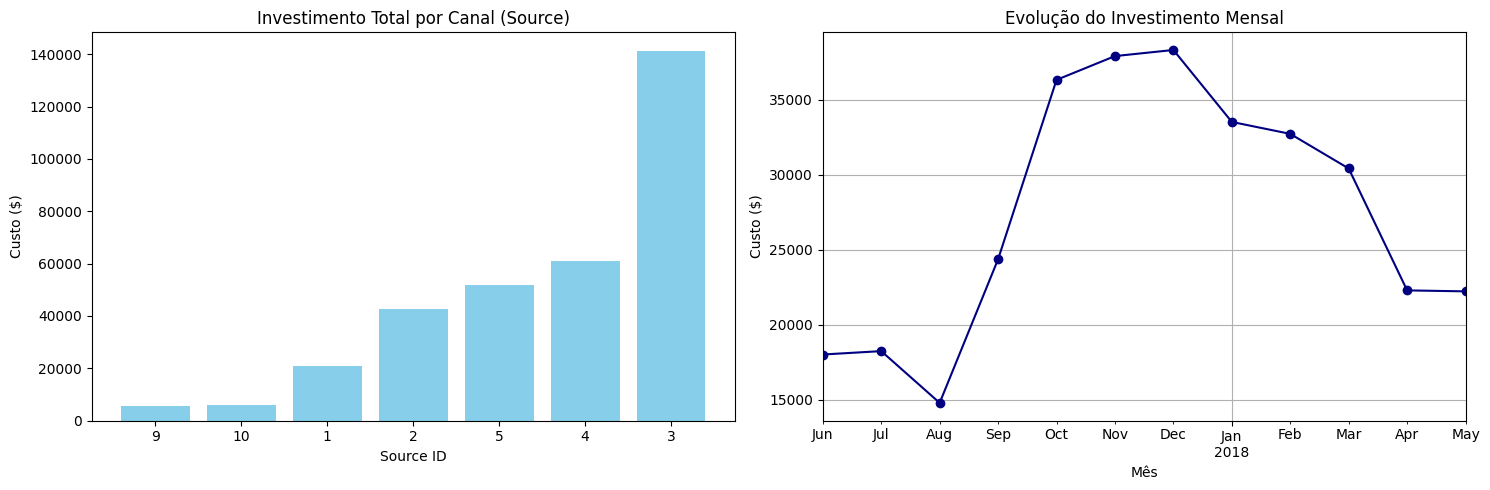

In [112]:
costs_df['month'] = costs_df['date'].dt.to_period('M').dt.to_timestamp()

# Gasto Total
total_spend = costs_df['costs'].sum()
print(f"Investimento Total em Marketing: ${total_spend:,.2f}")

# Gasto por Origem (Source)
costs_by_source = costs_df.groupby('source_id')['costs'].sum().reset_index()
print("\n--- Gasto por Origem ---")
print(costs_by_source.sort_values('costs', ascending=False))

# Gasto ao Longo do Tempo (Mensal)
costs_by_month = costs_df.groupby('month')['costs'].sum()

plt.figure(figsize=(15, 5))

# Gráfico 1: Custos por Origem
plt.subplot(1, 2, 1)
costs_by_source_sorted = costs_by_source.sort_values('costs')
plt.bar(costs_by_source_sorted['source_id'].astype(str), costs_by_source_sorted['costs'], color='skyblue')
plt.title('Investimento Total por Canal (Source)')
plt.xlabel('Source ID')
plt.ylabel('Custo ($)')

# Gráfico 2: Custos por Mês
plt.subplot(1, 2, 2)
costs_by_month.plot(kind='line', marker='o', color='navy', grid=True)
plt.title('Evolução do Investimento Mensal')
plt.xlabel('Mês')
plt.ylabel('Custo ($)')

plt.tight_layout()
plt.show()

### Quanto custou a aquisição de clientes para cada origem?

--- CAC por Origem (Do Menor para o Maior) ---
   source_id      costs  n_buyers    cac
6         10    5822.49      1329   4.38
5          9    5517.49      1088   5.07
3          4   61073.60     10296   5.93
0          1   20833.27      2899   7.19
4          5   51757.10      6931   7.47
1          2   42806.04      3506  12.21
2          3  141321.63     10473  13.49


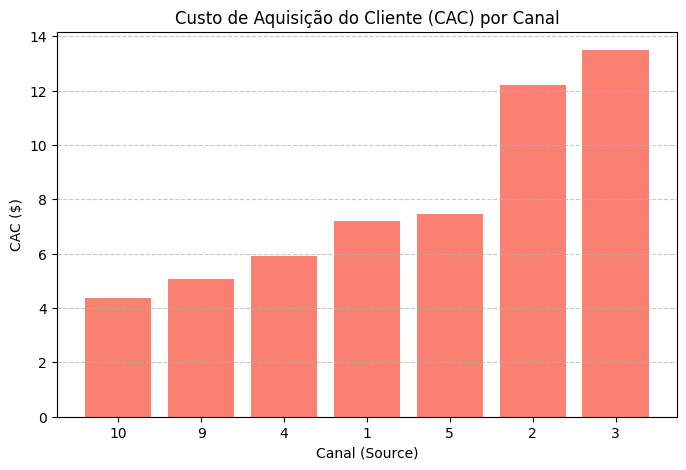

In [113]:
# Identificar a origem de cada comprador (baseado na primeira visita)
first_visit_source = visits_df.sort_values(['uid', 'start_ts']).groupby('uid').first()['source_id'].reset_index()
first_visit_source.columns = ['uid', 'source_id']

# Filtrar apenas os usuários que fizeram pedidos (Compradores)
paying_users = orders_df['uid'].unique()
buyers_source = first_visit_source[first_visit_source['uid'].isin(paying_users)]

# Contar compradores por origem
buyers_per_source = buyers_source.groupby('source_id')['uid'].count().reset_index()
buyers_per_source.columns = ['source_id', 'n_buyers']

# Juntar com os custos e calcular o CAC
cac_report = pd.merge(costs_by_source, buyers_per_source, on='source_id')
cac_report['cac'] = cac_report['costs'] / cac_report['n_buyers']

print("--- CAC por Origem (Do Menor para o Maior) ---")
print(cac_report.sort_values('cac').round(2))

# --- Gráfico do CAC ---
plt.figure(figsize=(8, 5))
cac_plot = cac_report.sort_values('cac')
plt.bar(cac_plot['source_id'].astype(str), cac_plot['cac'], color='salmon')
plt.title('Custo de Aquisição do Cliente (CAC) por Canal')
plt.xlabel('Canal (Source)')
plt.ylabel('CAC ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Aqui (logo acima) percebemos que o canal mais caro é o **3**, o mais barato é o canal **10**, e há os intermediários.

### Os investimentos valeram a pena? (ROI)

--- ROI Acumulado por Coorte (1.0 = Ponto de Equilíbrio) ---
age_month            0     1     2     3     4     5     6     7     8     9   \
first_order_month                                                               
2017-06            0.53  0.59  0.63  0.74  0.86  0.94  1.05  1.11  1.17  1.24   
2017-07            0.63  0.67  0.73  0.77  0.79  0.81  0.82  0.84  0.85  0.87   
2017-08            0.49  0.53  0.57  0.61  0.66  0.68   0.7  0.74  0.77  0.78   
2017-09             0.6  0.72  0.77  1.19  1.23   1.3  1.38   1.4  1.42         
2017-10             0.6  0.66  0.68   0.7  0.72  0.74  0.75  0.76               
2017-11            0.55   0.6  0.62  0.65  0.67  0.68  0.69                     
2017-12            0.54  0.57  0.68   0.8  0.84  0.87                           
2018-01            0.42  0.45  0.48  0.49   0.5                                 
2018-02            0.46  0.49   0.5  0.51                                       
2018-03            0.56   0.6  0.63             

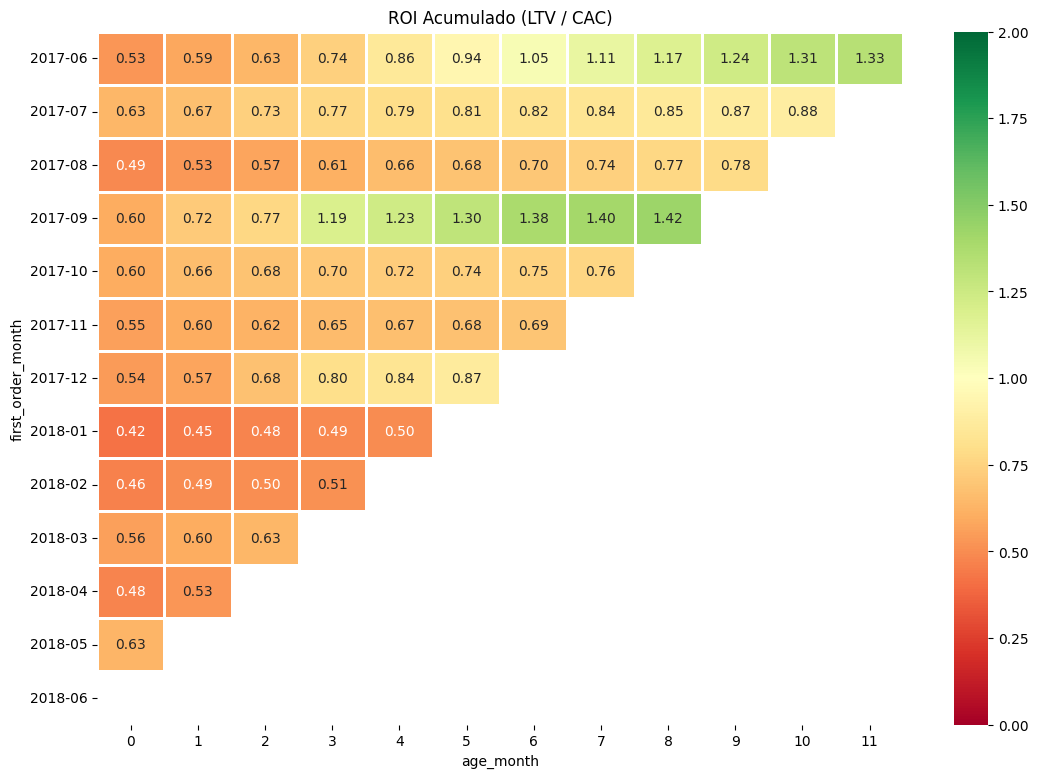

In [114]:
# Calcular o CAC por Coorte (Mês)
# Custo do Mês / Nº de Novos Compradores naquele Mês
monthly_costs = costs_df.groupby('month')['costs'].sum().reset_index()
monthly_costs.columns = ['first_order_month', 'month_costs']

cohort_report = pd.merge(cohort_sizes, monthly_costs, on='first_order_month')
cohort_report['cac_cohort'] = cohort_report['month_costs'] / cohort_report['n_buyers']

# Calcular o ROI (LTV / CAC)
# Pegamos o LTV Acumulado e dividimos pelo CAC daquela coorte
roi = ltv_cumulative.div(cohort_report.set_index('first_order_month')['cac_cohort'], axis=0)

print("--- ROI Acumulado por Coorte (1.0 = Ponto de Equilíbrio) ---")
roi_print = roi.copy()
roi_print.index = roi_print.index.strftime('%Y-%m')
print(roi_print.round(2).fillna(''))

# --- Gráfico de Calor (Heatmap) do ROI ---
plt.figure(figsize=(13, 9))
plt.title('ROI Acumulado (LTV / CAC)')
sns.heatmap(
    roi_print,
    annot=True,
    fmt='.2f',
    linewidths=1,
    linecolor='white',
    cmap='RdYlGn', # Vermelho (Prejuízo) -> Verde (Lucro)
    vmin=0, vmax=2 # Define o intervalo de cores (0 a 2x o retorno)
)
plt.show()

### Construa gráficos para ver como essas métricas diferem

<Figure size 1200x600 with 0 Axes>

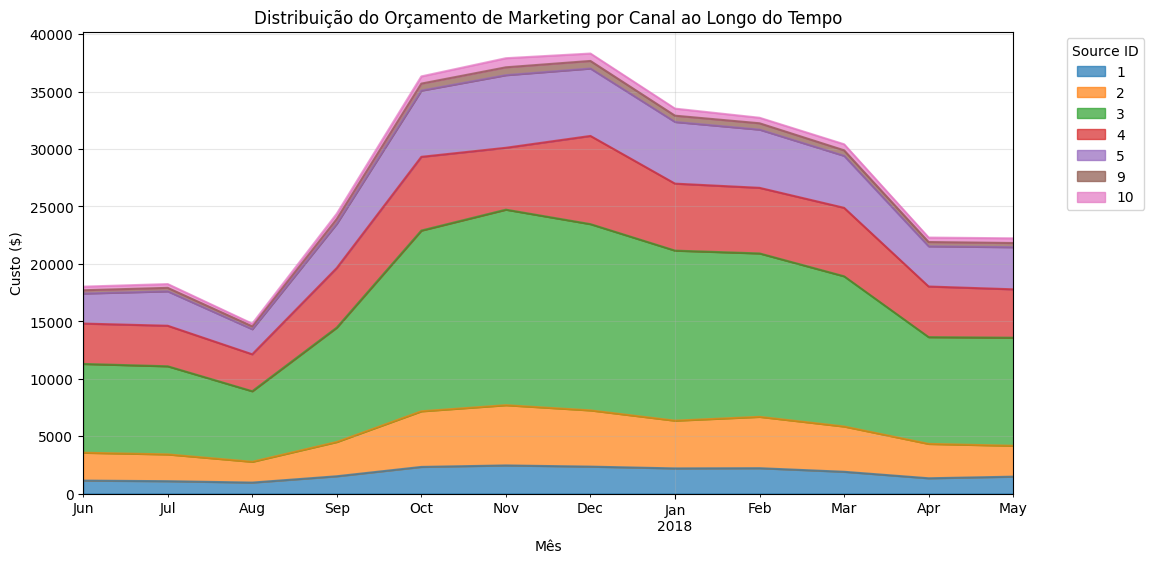

In [115]:
# --- Gráfico Extra: Evolução do CAC e Custos ---

# Custos ao Longo do Tempo por Canal
costs_pivot = costs_df.pivot_table(
    index='month',
    columns='source_id',
    values='costs',
    aggfunc='sum'
)

plt.figure(figsize=(12, 6))
costs_pivot.plot(kind='area', stacked=True, alpha=0.7, figsize=(12,6))
plt.title('Distribuição do Orçamento de Marketing por Canal ao Longo do Tempo')
plt.xlabel('Mês')
plt.ylabel('Custo ($)')
plt.legend(title='Source ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

--- Ranking de Lucratividade (ROI) ---
Acima de 1.0 = Lucro | Abaixo de 1.0 = Prejuízo
   source_id   revenue      costs   roi
0          1  31090.55   20833.27  1.49
1          2  46923.61   42806.04  1.10
5          9   5759.40    5517.49  1.04
4          5  52624.02   51757.10  1.02
3          4  56696.83   61073.60  0.93
6         10   4450.33    5822.49  0.76
2          3  54511.24  141321.63  0.39


/tmp/ipython-input-1744888890.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=roi_channel, x='source_id', y='roi', palette='viridis', order=roi_channel.sort_values('roi', ascending=False)['source_id'])


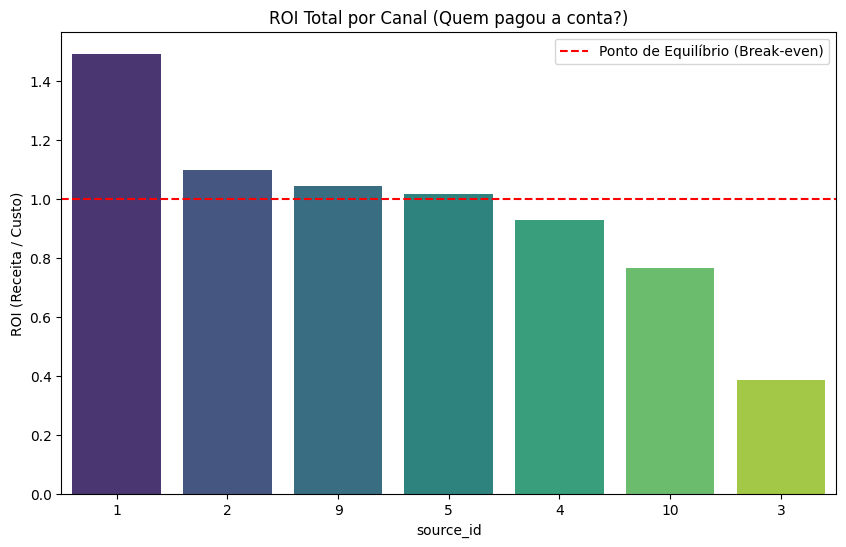

In [116]:
# Receita Total por Origem
user_revenue = orders_df.groupby('uid')['revenue'].sum().reset_index()

# Juntamos com a origem
revenue_source = pd.merge(user_revenue, first_visit_source, on='uid')
revenue_per_source = revenue_source.groupby('source_id')['revenue'].sum().reset_index()

# Custos Totais por Origem
costs_per_source = costs_df.groupby('source_id')['costs'].sum().reset_index()

# Juntar Receita e Custo
roi_channel = pd.merge(revenue_per_source, costs_per_source, on='source_id')

# Calcular o ROI (Receita / Custo)
roi_channel['roi'] = roi_channel['revenue'] / roi_channel['costs']

# Classificar do Melhor para o Pior
print("--- Ranking de Lucratividade (ROI) ---")
print("Acima de 1.0 = Lucro | Abaixo de 1.0 = Prejuízo")
print(roi_channel.sort_values('roi', ascending=False).round(2))

# --- Gráfico Final ---
plt.figure(figsize=(10, 6))
sns.barplot(data=roi_channel, x='source_id', y='roi', palette='viridis', order=roi_channel.sort_values('roi', ascending=False)['source_id'])
plt.axhline(1.0, color='red', linestyle='--', label='Ponto de Equilíbrio (Break-even)')
plt.title('ROI Total por Canal (Quem pagou a conta?)')
plt.ylabel('ROI (Receita / Custo)')
plt.legend()
plt.show()

O canal **2** destaca-se por atrair clientes de alto valor (LTV elevado), o que justifica seu Custo de Aquisição (CAC) mais alto, garantindo o 2º melhor retorno sobre investimento (ROI) da empresa.  
O canal **1** traz muitos clientes, com CAC mais baixo. É um canal eficiente e deve receber orçamento.

O investimento em marketing não é uniforme: alguns canais custam até 3x mais para trazer um cliente. A análise de ROI sugere cortar verba do Canal 3 (caro e retorno lento) e reinvestir nos canais **1** e **2**.

## 5. Conclusão

### Conclusão e Recomendações de Investimento
Após analisar o comportamento dos usuários (Coortes e LTV) e os custos de marketing (CAC), chegamos ao veredito sobre a eficiência de cada canal. A recomendação baseia-se na métrica principal de **ROI (Retorno sobre Investimento)**, pois ela equilibra o custo de trazer o cliente com o valor que ele realmente gasta.

### 1. Onde Investir (Aumentar Orçamento)
* **Source 1:** É o canal "Estrela". Apresenta consistentemente o **melhor ROI** da empresa. Recomendamos aumentar agressivamente o investimento aqui, pois cada dólar gasto retorna com lucro significativo.
* **Source 2:** O canal "Premium". Embora tenha um **CAC (Custo de Aquisição) alto**, ele atrai clientes de **LTV (Valor) muito elevado**, garantindo o 2º melhor ROI. Recomendamos manter o investimento, focando em campanhas de alta qualidade para esse público que gasta mais.
* **Sources 5, 9 e 10:** São canais de "Baixo Custo e Alta Eficiência". O CAC é baixíssimo e o ROI é positivo. São excelentes para capturar volume de usuários sem inflacionar o orçamento. Vale a pena testar aumentar a verba aqui para ver se a escala se mantém.

### 2. Onde Cortar ou Otimizar (Reduzir Orçamento)
* **Source 3:** É o "Vilão" da eficiência. Apresenta um **CAC muito elevado** que não é compensado pelo LTV dos clientes (ROI baixo ou negativo). Recomendamos reduzir drasticamente a verba deste canal imediatamente e realocá-la para o Source 1.
* **Source 4:** Apesar de ter alta conversão imediata (usuários compram rápido), o custo para trazê-los está corroendo a margem. Exige revisão das campanhas para baixar o CAC.

### 3. Fundamentação da Escolha (Por que decidimos isso?)
Nossa decisão não foi baseada apenas em "quem traz mais gente" (Volume), mas em "quem traz lucro" (Eficiência).

* **Métrica Foco:** O ROI foi o fiel da balança. Canais baratos que não trazem receita (LTV baixo) foram descartados, e canais caros que trazem clientes valiosos (como o Source 2) foram valorizados.
* **A Descoberta:** O maior volume de investimento estava indo para o Source 3, que é ineficiente. A simples realocação dessa verba para o Source 1 e 2 pode aumentar a receita da Y.Afisha sem precisar gastar nenhum centavo a mais no total.

*"A estratégia sugerida é parar de 'comprar visitas caras' no Canal 3 e passar a 'investir em clientes lucrativos' nos Canais 1 e 2."*